# Self-Attention and Positional Encoding

Prior to the introduction of _attention mechanism_, it was common practice in deep learning to use CNNs or RNNs to encode sequences. However, now with attention mechanisms in the scene, imagine feeding a sequence of tokens into an attention mechanism such that at each step, each token has its own query, keys, and values. Here, when computing the value of a token's representation at the next layer, the token can attend (via its query vector) to each other token (matching based on their key vectors). Using the full set of query-key compatibility scores, we can compute, for each token, a representation building the appropriate weighted sum over the other tokens. Because each token is attending to each other token (unlike the case where decoder steps attend to encoder steps), such architectures are typically described as _self-attention_ models, sometimes also referred as _infra-attention_ model.  

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## Self-Attention

Using multi-head attention, the following code snippet computes the self-attention of a tensor with shape (batch size, number of time steps or sequence length in tokens,_d_). The output tensor has the same shape.

In [3]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
d2l.check_shape(attention(X, X, X, valid_lens),
                (batch_size, num_queries, num_hiddens))

## Comparing CNNs, RNNs, and Self-Attention

Let's compare architectures for mapping a sequence of $n$ tokens to another sequence of equal length, where each input or output token is represented by a $d$-dimensional vector.

__Architectures used to map a sequence of $n$ tokens to another sequence of equal length.__

- _Input_: $d$-dimensional vector
- _Output_: $d$-dimensional vector.

We will be comparing CNNs, RNNs, and Self-Attention in the following aspects: 

- Computational Complexity
- Sequential Operations: _prevent parallel computation_
- Maximum Path Length: _a shorter path between any combination of sequences postions makes it easier to learn long-range dependencies within the sequence._ (Hochreiter et al., 2001)

### CNNs

Consider a convolutional layer whose kernel size is $k$.For now, we only need to know that since the sequence length is $n$, the numbers of input and output channels are both $d$, the computational complexity of the convolutional layer is $\mathcal{O}(knd^2)$.CNNs are hierarchical, so there are $\mathcal{O}(1)$ sequential operations and the maximum path length is $\mathcal{O}(n/k)$. For example, $\mathbf{x}_1$ and $\mathbf{x}_5$ are within the receptive field of a two-layer CNN with kernel size 3 . 
* __Computational Complexity__: $\mathcal{O}(knd^2)$
* __Sequential Operations__: $\mathcal{O}(1)$
* __Maximum Path Length__: $\mathcal{O}(n/k)$

### RNNs

When updating the hidden state of RNNs, multiplication of the $d \times d$ weight matrix and the $d$-dimensional hidden state has 
a computational complexity of $\mathcal{O}(d^2)$. Since the sequence length is $n$, the computational complexity of the recurrent layer
is $\mathcal{O}(nd^2)$. There are $\mathcal{O}(n)$ sequential operations that cannot be parallelized and the maximum path length is also $\mathcal{O}(n)$.

* __Computational Complexity__: $\mathcal{O}(d^2)$.
* __Sequential Operations__: $\mathcal{O}(n)$ (cannot be parallelized)
* __Maximum Path Length__: $\mathcal{O}(n)$

### Self-Attention

In self-attention, the queries, keys, and values are all $n \times d$ matrices. Consider the scaled dot-product attention, where a    $n \times d$ matrix is multiplied by
a $d \times n$ matrix,
then the output $n \times n$ matrix is multiplied
by a $n \times d$ matrix.
As a result,
the self-attention
has a $\mathcal{O}(n^2d)$ computational complexity.
As we can see,
each token is directly connected
to any other token via self-attention.
Therefore,
computation can be parallel with $\mathcal{O}(1)$ sequential operations
and the maximum path length is also $\mathcal{O}(1)$.

* __Computational Complexity__: $\mathcal{O}(n^2d)$
* __Sequential Operations__: $\mathcal{O}(1)$ (can be parallelized)
* __Maximum Path Length__: $\mathcal{O}(1)$.

In resume, both CNNs, and self-attention enjoy parallel computation and self-attention has the shortest maximum path length. However, the quadratic computational complexity with respect to the sequence length makes self-atention prohibitively slow for very long sequences.


## Positional Encoding

Unlike RNNs, which recurrently proces tokens of a sequencey one by one, self-attention ditches sequential operations in favor of parallel computation. Note, however, that _self-attention by itself does not preserve the order of the sequence._

### Question: __What do we do if it really matters that the model knows in which order the input sequence arrived__?

The dominant approach for preserving information about the order of tokens is _to represent this to the model as an additional input associated with each token_. These inputs are called, __positional encodings__, and they can either be learned or fixed a priori. 

__Positional Encodings:__ are additional inputs that are fed to the model preserving informatin about the order of the tokens.

In [4]:
class PositionalEncoding(nn.Module):  #@save
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In the positional embedding matrix $\mathbf{P}$,
[**rows correspond to positions within a sequence
and columns represent different positional encoding dimensions**].
In the example below,
we can see that
the $6^{\mathrm{th}}$ and the $7^{\mathrm{th}}$
columns of the positional embedding matrix 
have a higher frequency than 
the $8^{\mathrm{th}}$ and the $9^{\mathrm{th}}$
columns.
The offset between 
the $6^{\mathrm{th}}$ and the $7^{\mathrm{th}}$ (same for the $8^{\mathrm{th}}$ and the $9^{\mathrm{th}}$) columns
is due to the alternation of sine and cosine functions.

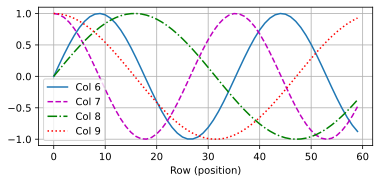

In [5]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

In self-attention, the queries, keys, and values all come from the same place. Both CNNs and self-attention enjoy parallel computation and self-attention has the shortest maximum path length. However, the quadratic computational complexity with respect to the sequence length makes self-attention prohibitively slow for very long sequences. To use the sequence order information, we can inject absolute or relative positional information by adding positional encoding to the input representations.